# Modèle non-lineaire - Activation function

Résolution du problème inverse d'intégrale multiple
Pour un réseau de neurones Unfolding
Chaque couche n'a que trois paramètres.

On rappelle le modèle.
We set an initial value $x_0$ and
we introduce the following $m$-layer neural network

\begin{equation}
	\label{def:modelG}
	\begin{cases}
	\textbf{Initialization:} \\
	\quad b_0 = T^*y^\delta ,\\
	\textbf{Layer $n\in \{1,\ldots,m\}$:} \\
      \quad x_n %=  Q_n(x_0,x_{n-1}) 
          = R_n(W_n x_{n-1} + W_{n,0}b_0)\;,
    \end{cases}		  
\end{equation}
where 
\begin{align}
&R_n = \text{prox}_{\lambda_n \mu_n g}\\
&W_n =  1 - \lambda_n T^*T - \lambda_n \alpha_n D^*D \\
&W_{n,0} = \lambda_n 1.
\end{align}

Dansd un premier temps on apprend seulement le paramètre $\alpha$,
on fait 10 couches, et on a un prox Relu.

In [2]:
import numpy as np
# pytorch
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Data

x -> (features) intégrale de y (bruité) sur $[0,l]$ correspondant au moment d'ordre 0 bruité ;

y -> (labels) distribution sur $[0,l]$.

In [3]:
# Physical data
l = 200
tau = 100
dep = 2
# Numerical data
nx = 200
dx = l/(nx+1)
nt = 200
dt = tau/nt
T_operator = 1/100*dx*np.tri(nt, nx, 0, dtype=int)
# Data sample
nsamp = 400
x_dagger = np.zeros((nsamp,nx))
y = np.zeros((nsamp,nt))
x_grid = np.linspace(0,l,nx)
#
x_sample = np.zeros((nsamp,nx))
#
for i in range(0,nsamp):
    mu = l/2
    sigma = 0.1
    x_dagger[i] = (sigma*np.sqrt(2*np.pi))**-1*np.exp(-(x_grid-mu)**2/2*sigma**2)
    y[i] = T_operator.dot(x_dagger[i]) 
    xi = np.random.uniform(-0.005,0.005,nt)
    y[i] += xi*np.linalg.norm(y[i])/np.linalg.norm(xi)
    x_sample[i] = np.transpose(T_operator).dot(y[i])

In [4]:
x_tensor = torch.from_numpy(x_sample)
y_tensor = torch.from_numpy(x_dagger)

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [300, 100])

train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

In [5]:
train_loader

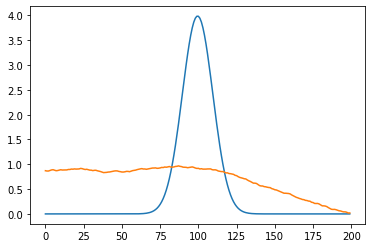

In [7]:
# Check
plt.plot(train_dataset[0][1])
plt.plot(train_dataset[0][0])

In [8]:
# Regularisation operator
D_operator = np.diag(np.ones(nx-1),1)+ np.diag(np.ones(nx-1),-1)-2*np.eye(nx)

## Model 

In [19]:
class MyModel(nn.Module):
    def __init__(self, number_of_layers, T, D, nx):
        super().__init__()
        self.alpha = [nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))\
                      for k in range(number_of_layers)]
#         self.linear_output_transformation = nn.Linear(weight_dimensions, number_of_classes,\
#                                                       bias=False)
        self.activation_function = nn.Tanh()        
        self.number_of_layers = number_of_layers
        # Physical model
        self.T = torch.from_numpy(np.transpose(T).dot(T))
        self.D = torch.from_numpy(np.transpose(D).dot(D))
        self.nx = nx
        
    
    def forward(self, x):
        y = torch.transpose(x,0,-1)
        for k in range(self.number_of_layers):
            tensor_grad = torch.eye(nx)\
              - self.T \
              - self.alpha[k]*self.D
            y = torch.matmul(tensor_grad,y)
            y = self.activation_function(y)
        return torch.transpose(y,0,-1)

In [20]:
model = MyModel(10, T_operator, D_operator, nx)

In [21]:
y_pred = model.forward(train_dataset[0][0])

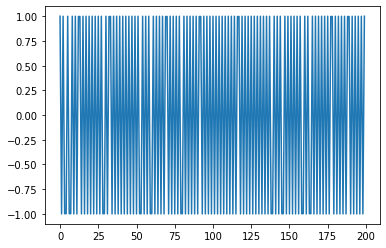

In [22]:
plt.plot(y_pred.detach().numpy())

## Training

In [23]:
loss_fn = nn.MSELoss(reduction='mean')

In [24]:
lr = 1e-1
# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.alpha, lr=lr)

In [25]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

In [26]:
# Creates the train_step function for our model, 
# loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)


In [27]:
losses = []
val_losses = []
n_epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            model.eval()

            yhat = model(x_val)
            val_loss = loss_fn(y_val, yhat)
            val_losses.append(val_loss.item())

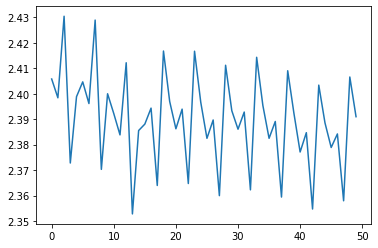

In [28]:
plt.plot(val_losses)

In [32]:
model.alpha

[Parameter containing:
 tensor([-2.6097], requires_grad=True),
 Parameter containing:
 tensor([0.8997], requires_grad=True),
 Parameter containing:
 tensor([-0.5488], requires_grad=True),
 Parameter containing:
 tensor([1.8379], requires_grad=True),
 Parameter containing:
 tensor([-1.6149], requires_grad=True),
 Parameter containing:
 tensor([0.8602], requires_grad=True),
 Parameter containing:
 tensor([-0.1999], requires_grad=True),
 Parameter containing:
 tensor([0.5574], requires_grad=True),
 Parameter containing:
 tensor([0.6577], requires_grad=True),
 Parameter containing:
 tensor([-0.5295], requires_grad=True)]